In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear
from utils import get_firing_field, get_field_metrics
import configs

device = 'cpu'

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/Users/chingfang/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


# Load existing results

In [ ]:
desired_sigmas = ['sigma1.75', 'sigma2.0']
desired_sparsity_range = [0.1, 0.19]
gamma = 0.75
model = 'rnn'

In [7]:
results_dirs = []
data_dir = f'{configs.engram_dir}03_hannah_dset/'
for sparsity in os.listdir(data_dir):
    if not os.path.isdir(f'{data_dir}{sparsity}'): continue
    sigma_dirs = os.listdir(f'{data_dir}{sparsity}')
    for desired_sigma in desired_sigmas:
        if desired_sigma in sigma_dirs:
            results_dir = f'{data_dir}{sparsity}/{desired_sigma}/{gamma}/{model}/0/'
            results_path = results_dir + 'results.p'
            with open(results_path, 'rb') as f:
                results = pickle.load(f)
            dset = results['dset']
            final_sparsity = dset.feature_maker.post_smooth_sparsity
            if final_sparsity >= desired_sparsity_range[0]:
                if final_sparsity <= desired_sparsity_range[1]:
                    results_dirs.append(results_dir)

In [8]:
print(len(results_dirs))
results_dirs

24


['/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.019526315789473683/sigma1.75/0.75/rnn/0/',
 '/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.040368421052631574/sigma1.75/0.75/rnn/0/',
 '/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.03573684210526316/sigma1.75/0.75/rnn/0/',
 '/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.031105263157894733/sigma1.75/0.75/rnn/0/',
 '/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.03178947368421053/sigma2.0/0.75/rnn/0/',
 '/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.017210526315789475/sigma1.75/0.75/rnn/0/',
 '/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.03342105263157895/sigma1.75/0.75/rnn/0/',
 '/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.021526315789473685/sigma2.0/0.75/rnn/0/',
 '/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.021842105263157892/sigma1.75/0.75/rnn/0/',
 '/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.023578947368421053/sigma2.0/0.75/rnn/0/',
 '/Volumes/arono

In [10]:
results_dir = '/Volumes/aronov-locker/Ching/03_td_discrete_corr/sparsity0.021526315789473685/sigma2.0/0.4/rnn_oja/0/'

In [11]:
results_path = results_dir + 'results.p'
fieldinfos_path = results_dir + 'field_infos.p'
with open(results_path, 'rb') as f:
    results = pickle.load(f)
if os.path.isfile(fieldinfos_path):
    with open(fieldinfos_path, 'rb') as f:
        fieldinfos = pickle.load(f)
if 'hopfield' in results_path:
    outputs = results['outputs'].detach().numpy().squeeze()
else:
    outputs = results['outputs']
dset = results['dset']

print('Sigma:')
print(dset.feature_maker.spatial_sigma)
print('Sparsity:')
print(dset.feature_maker.post_smooth_sparsity)

Sigma:
2.0
Sparsity:
0.13070059369873271


In [12]:
walk_xs = dset.xs
walk_ys = dset.ys
arena_length = int(np.sqrt(outputs.shape[1]))

### Make Plots

In [9]:
from scipy import ndimage
import matplotlib.gridspec as gridspec

In [10]:
def plot_fields(results_dir):
    results_path = results_dir + 'results.p'
    fieldinfos_path = results_dir + 'field_infos.p'
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    if os.path.isfile(fieldinfos_path):
        with open(fieldinfos_path, 'rb') as f:
            fieldinfos = pickle.load(f)
    if 'hopfield' in results_path:
        outputs = results['outputs'].detach().numpy().squeeze()
    else:
        outputs = results['outputs']
    dset = results['dset']

    print('Sigma:')
    print(dset.feature_maker.spatial_sigma)
    print('Sparsity:')
    print(dset.feature_maker.post_smooth_sparsity)

    walk_xs = dset.xs
    walk_ys = dset.ys
    arena_length = int(np.sqrt(outputs.shape[1]))

    grid_x = 4; grid_y = 4;

    plt.figure(figsize = (6, 6))
    gs1 = gridspec.GridSpec(grid_x, grid_y)
    gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

    neurs = np.arange(outputs.shape[1])
    np.random.shuffle(neurs)

    idx = 0
    for neur in neurs:
        ff, mask = get_firing_field(
            walk_xs, walk_ys, outputs[:,neur],
            arena_length, normalize=True
            )
        ax = plt.subplot(gs1[idx])
        plt.axis('on')
        if np.sum(fieldinfos[neur][1]) == 0: continue # Skip non-place cells
        ff = ff - ff.min()
        #ff *= fieldinfos[neur][1]
        ax.imshow(ff/ff.max(), vmin=0., vmax=1, cmap='viridis')
        ax.set_xticks([])
        ax.set_yticks([])

        idx += 1
        if idx == grid_x*grid_y: break
    plt.suptitle('Simulated Place Fields')
    plt.tight_layout()
    plt.savefig('5c_fields', dpi=300)
    plt.show()

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.019526315789473683/sigma1.75/0.75/rnn/0/
Sigma:
1.75
Sparsity:
0.12284093095411017


/Users/chingfang/Code/sr-project/notebooks/utils.py:47: RuntimeWarning: Mean of empty slice
  fr = np.nanmean(activity[frame_idxs])
/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_36105/3922817467.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


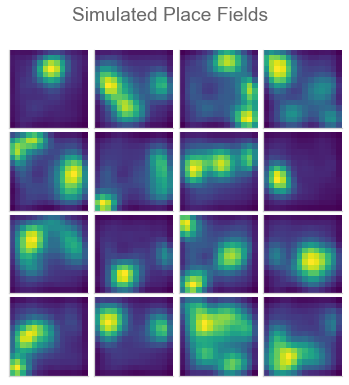

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.040368421052631574/sigma1.75/0.75/rnn/0/
Sigma:
1.75
Sparsity:
0.18411786520623585


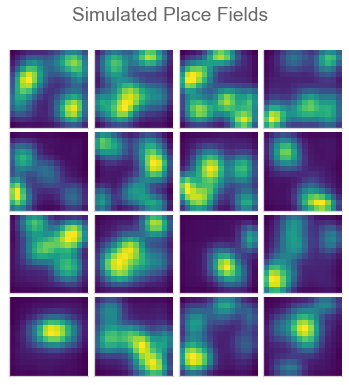

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.03573684210526316/sigma1.75/0.75/rnn/0/
Sigma:
1.75
Sparsity:
0.16931890529410826


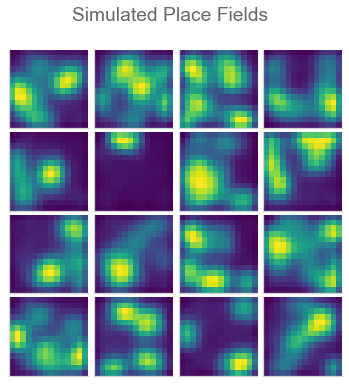

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.031105263157894733/sigma1.75/0.75/rnn/0/
Sigma:
1.75
Sparsity:
0.16786158578242868


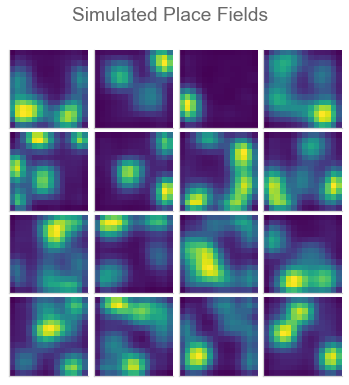

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.03178947368421053/sigma2.0/0.75/rnn/0/
Sigma:
2.0
Sparsity:
0.1691607267916145


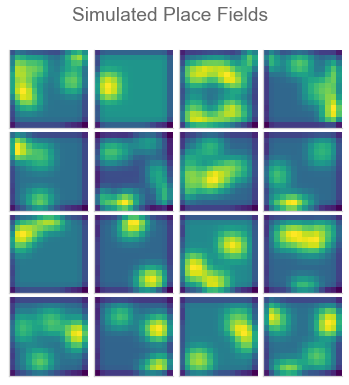

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.017210526315789475/sigma1.75/0.75/rnn/0/
Sigma:
1.75
Sparsity:
0.10328016286714375


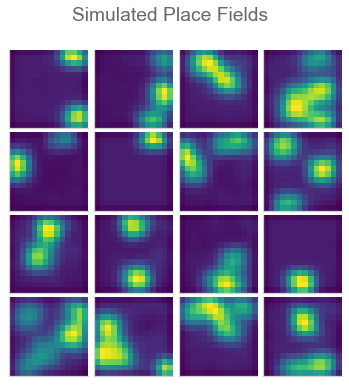

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.03342105263157895/sigma1.75/0.75/rnn/0/
Sigma:
1.75
Sparsity:
0.16684842813122297


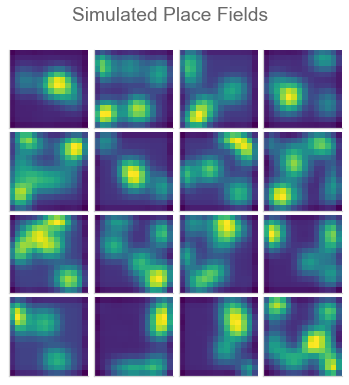

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.021526315789473685/sigma2.0/0.75/rnn/0/
Sigma:
2.0
Sparsity:
0.12586543958538607


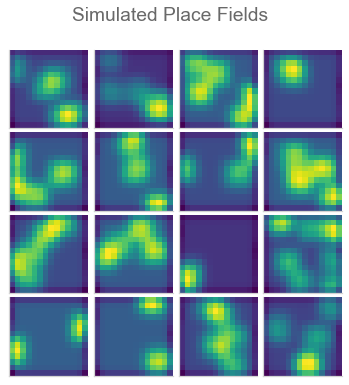

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.021842105263157892/sigma1.75/0.75/rnn/0/
Sigma:
1.75
Sparsity:
0.13056440034158018


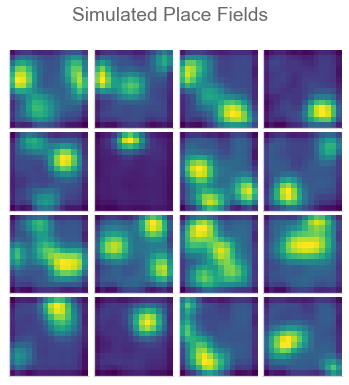

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.023578947368421053/sigma2.0/0.75/rnn/0/
Sigma:
2.0
Sparsity:
0.14263742464830442


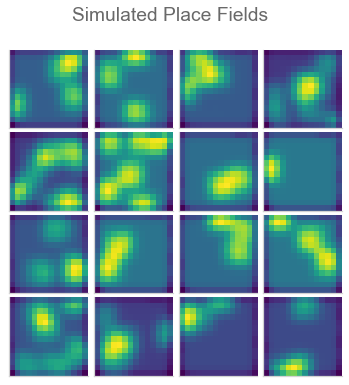

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.01536842105263158/sigma2.0/0.75/rnn/0/
Sigma:
2.0
Sparsity:
0.11038960153250871


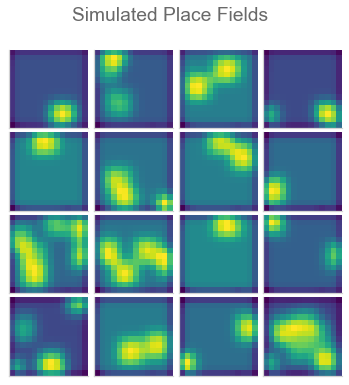

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.035894736842105264/sigma2.0/0.75/rnn/0/
Sigma:
2.0
Sparsity:
0.18837698793161706


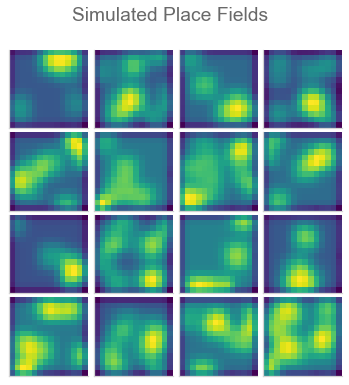

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.014894736842105263/sigma1.75/0.75/rnn/0/
Sigma:
1.75
Sparsity:
0.10667833855534568


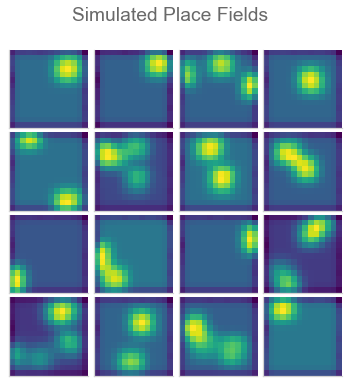

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.025631578947368422/sigma2.0/0.75/rnn/0/
Sigma:
2.0
Sparsity:
0.14577023429410726


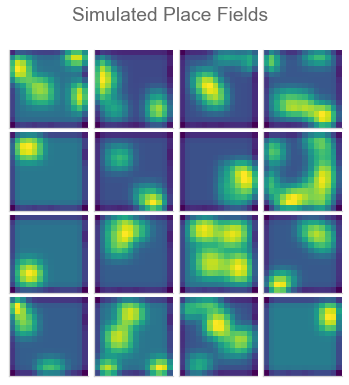

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.038052631578947366/sigma1.75/0.75/rnn/0/
Sigma:
1.75
Sparsity:
0.177606211701282


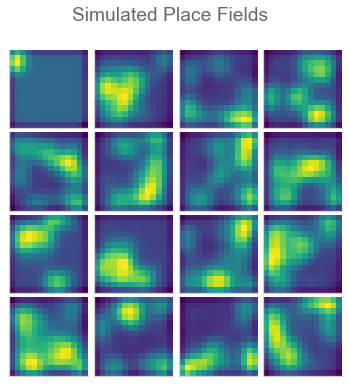

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.02768421052631579/sigma2.0/0.75/rnn/0/
Sigma:
2.0
Sparsity:
0.16647215379945945


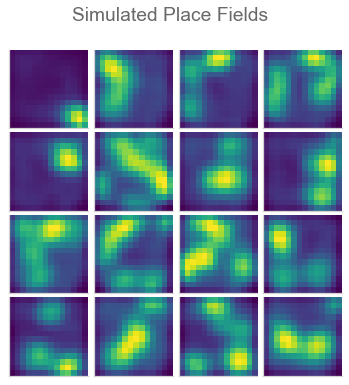

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.019473684210526317/sigma2.0/0.75/rnn/0/
Sigma:
2.0
Sparsity:
0.13597186944722678


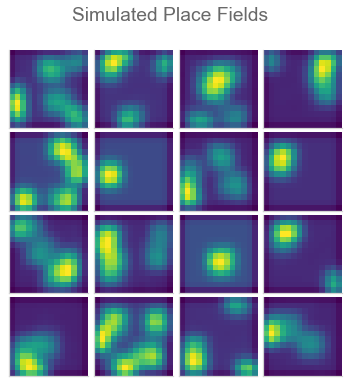

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.033842105263157896/sigma2.0/0.75/rnn/0/
Sigma:
2.0
Sparsity:
0.1748979323855019


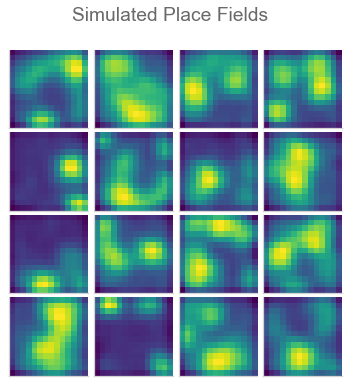

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.02973684210526316/sigma2.0/0.75/rnn/0/
Sigma:
2.0
Sparsity:
0.15982438394188359


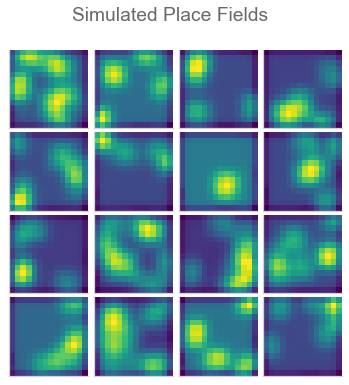

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.024157894736842104/sigma1.75/0.75/rnn/0/
Sigma:
1.75
Sparsity:
0.14637633410729972


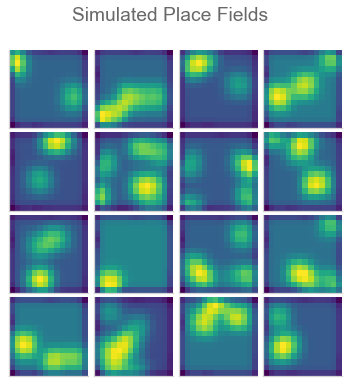

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.028789473684210524/sigma1.75/0.75/rnn/0/
Sigma:
1.75
Sparsity:
0.1538894671301675


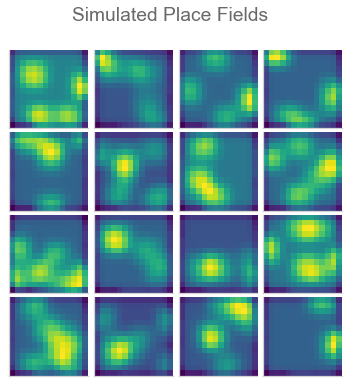

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.026473684210526316/sigma1.75/0.75/rnn/0/
Sigma:
1.75
Sparsity:
0.15197943818266346


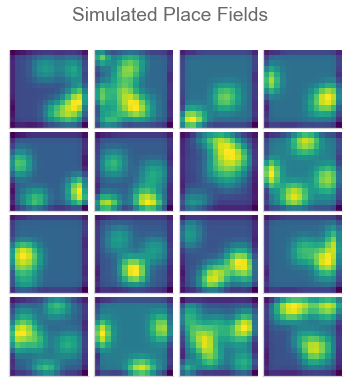

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.017421052631578948/sigma2.0/0.75/rnn/0/
Sigma:
2.0
Sparsity:
0.11863859857399538


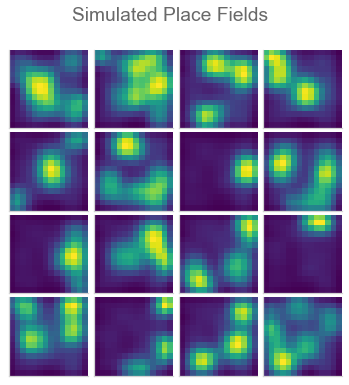

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.013315789473684211/sigma2.0/0.75/rnn/0/
Sigma:
2.0
Sparsity:
0.10388178834475756


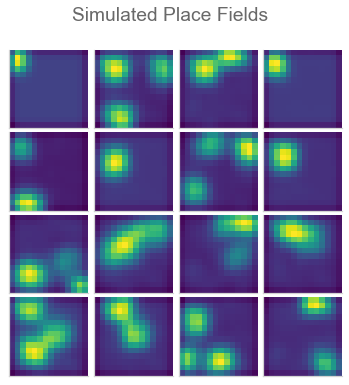

In [11]:
for x in results_dirs:
    print(x)
    plot_fields(x)

Sigma:
2.0
Sparsity:
0.12569605847603188


/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_36105/3922817467.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


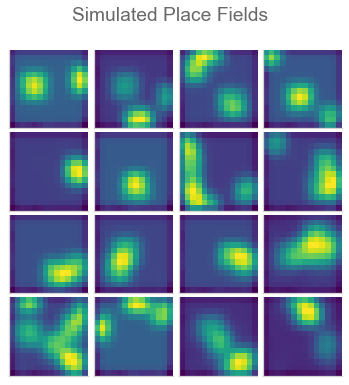

In [24]:
plot_fields('/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.019473684210526317/sigma2.0/0.75/rnn/6/')

### Metrics

In [59]:
fieldsize, nfield, onefield = get_field_metrics(outputs, dset, arena_length, nshuffles=10)

In [60]:
print(f'Fieldsize: {fieldsize}')
print(f'# Fields: {nfield}')
print(f'Ratio One Field: {onefield}')

Fieldsize: 0.05999538319482919
# Fields: 2.7075
Ratio One Field: 0.0875
